In [1]:
import matplotlib.pyplot as plt
import numpy as np

import sklearn
from sklearn.mixture import GaussianMixture

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [2]:
import sys
sys.path.append('../')
import adaprobe

In [3]:
data = np.load('data/one_cell_per_plane_sample_data.npz')

In [73]:
y = data['y']
stimulus_matrix = data['stimulus_matrix']
y_psc = data['y_psc']
N, K = stimulus_matrix.shape
trial_length = y_psc.shape[1]
n_repeats = K//N

In [137]:
# configure priors
phi_prior = np.c_[0.1 * np.ones(N), 5 * np.ones(N)]
phi_cov_prior = np.array([np.array([[1e-1, 0], [0, 1e0]]) for _ in range(N)])
beta_prior = 3e0 * np.ones(N)
mu_prior = np.zeros(N)

priors = {
    'beta': beta_prior,
    'mu': mu_prior,
    'phi': phi_prior,
    'phi_cov': phi_cov_prior
}

fit_options = {
    'iters': 100,
    'num_mc_samples': 20,
    'seed': 0
}

model = adaprobe.Model(np.zeros(N), priors=priors)

In [138]:
model.reset()
model.fit(y, stimulus_matrix, fit_options=fit_options, method='cavi_offline_spike_and_slab_NOTS_jax')

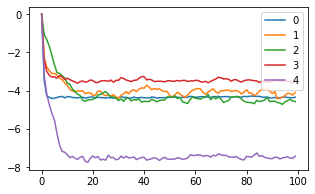

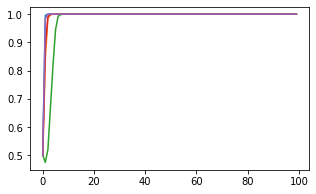

In [139]:
plt.figure(figsize=(5, 3))
plt.plot(model.history['mu'])
plt.legend(range(N))
plt.show()

plt.figure(figsize=(5, 3))
plt.plot(model.history['alpha'])
plt.show()

In [140]:
lam = np.array(model.state['lam']).T

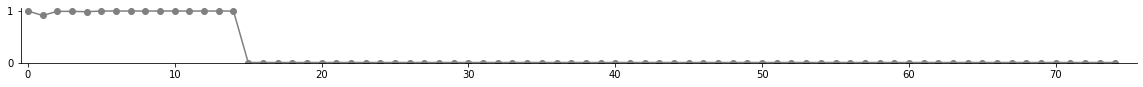

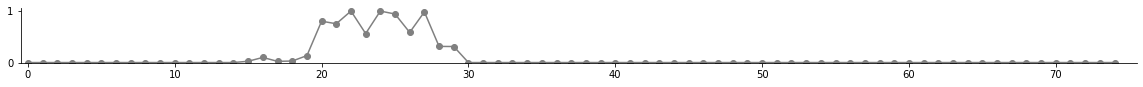

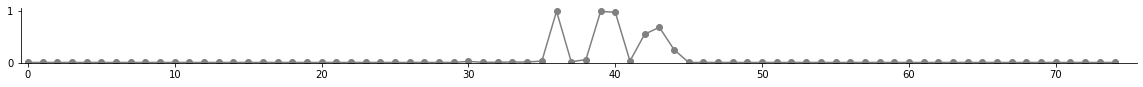

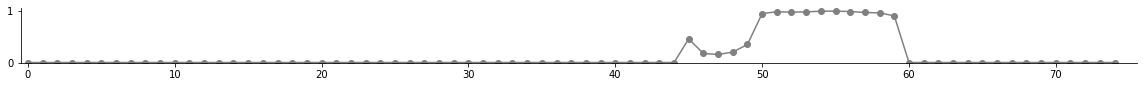

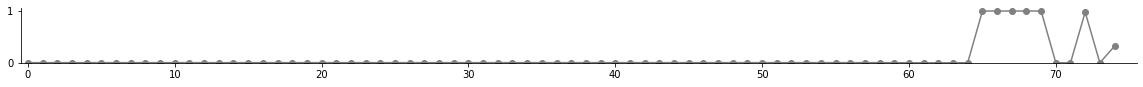

In [141]:
for n in range(N):
    plt.figure(figsize=(20, 1))
    plt.plot(np.arange(K), lam[n], 'o-', color='gray')
    plt.ylim([0, 1.05])
    plt.xlim([-1/2, K+1/2])
    for loc in ['top', 'right']:
        plt.gca().spines[loc].set_visible(False)
    plt.show()

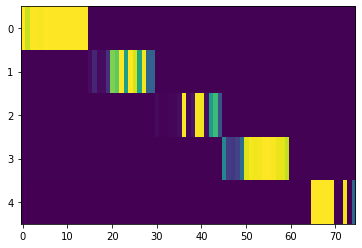

In [142]:
plt.imshow(lam, aspect='auto')

In [187]:
fontsize=13

<ipython-input-195-2e84da7ae7c5>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([np.round(np.min(y_psc), 2), 0.])


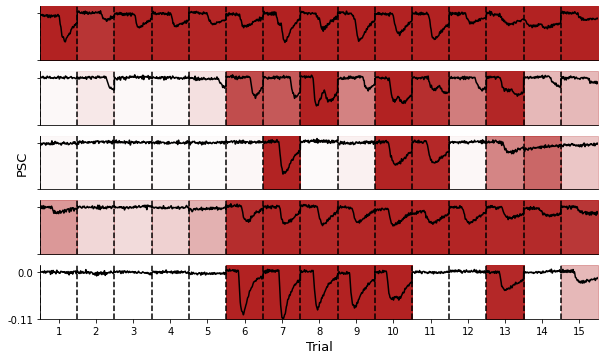

In [195]:
trial_breaks = np.arange(0, trial_length * n_repeats + 1, trial_length)

plt.figure(figsize=(10, 1.15 * N))
    
for n in range(N):
    plt.subplot(N, 1, n + 1)
    stim_locs = np.where(stimulus_matrix[n] > 0)[0]
    this_y_psc = y_psc[stim_locs].flatten()/np.max(np.abs(y_psc))
#     fill_lower, fill_upper = np.min(this_y_psc), np.max(this_y_psc)
    fill_lower = -1
    fill_upper = 0.15
    plt.xlim([0, trial_length*n_repeats])
    plt.ylim([-1, 0.15])
    for tb in range(len(trial_breaks) - 1):
        plt.plot([trial_breaks[tb], trial_breaks[tb]], [-1, 0.15], '--', color='k')
        plt.fill_between(np.arange(trial_length * tb, trial_length * (tb + 1)), fill_lower * np.ones(trial_length), fill_upper * np.ones(trial_length), color='firebrick', alpha=lam[n, stim_locs][tb])
    plt.plot(this_y_psc, color='k')
    for loc in ['top', 'right']:
        plt.gca().spines[loc].set_visible(False)
    
    if n == N-1:
        plt.xticks(trial_breaks[:-1] + trial_length/2)
        plt.gca().set_xticklabels(np.arange(1, n_repeats+1))
        plt.gca().set_yticklabels([np.round(np.min(y_psc), 2), 0.])
        plt.xlabel('Trial', fontsize=fontsize)
    elif n == N//2:
        plt.ylabel('PSC', fontsize=fontsize)
        plt.xticks([])
        plt.gca().set_yticklabels([])
    else:
        plt.xticks([])
        plt.gca().set_yticklabels([])

plt.show()

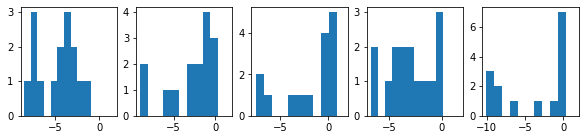

In [144]:
panel_size = 2
plt.figure(figsize=(panel_size * N, panel_size))
for n in range(N):
    plt.subplot(1, N, n+1)
    trial_locs = np.where(stimulus_matrix[n] > 0)[0]
    plt.hist(y[trial_locs])
    plt.xlim(right=2)
plt.show()

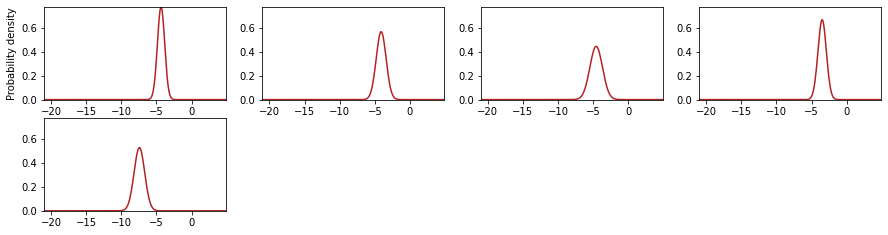

In [145]:
xrange = np.arange(-21, 5, 0.1)
def gaussf(mean, sdev):
    return 1/(np.sqrt(2 * np.pi * sdev**2)) * np.exp(-1/(2 * sdev**2) * (xrange - mean)**2)

def plot_connections(model, legend=[]):    
    post = [model.state['alpha'][n] * gaussf(model.state['mu'][n], model.state['beta'][n]) for n in range(N)]
    postmax = np.max(post)
    plt.figure(figsize=(15, 3*(N/4)))
    for n in range(N):
        plt.subplot(int(np.ceil(N/4)), 4, n + 1)
        plt.plot(xrange, post[n], color='firebrick')
        plt.xlim(np.min(xrange), np.max(xrange))
        plt.ylim([0, postmax])
        if n == 0:
            plt.xlabel('Synaptic strength')
            plt.ylabel('Probability density')
        if n == 0 and legend is not None:
            plt.legend(legend, loc='upper left', frameon=False)
    plt.show()

plot_connections(model)